In [ ]:
# Reseteamos todas las variables del entorno
%reset

# IMPORT LIBRARIES

# Processing
import librosa
import librosa.display
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython.display as ipd

# Files
import os
import joblib
import pickle

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
import tensorflow as tf

# ####### TEST ####### 
# Scipy
from scipy import signal
from scipy.io import wavfile

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## **CONFIGURACION DEL ENTORNO**

Configuramos el entorno para que nos deje acceder a los archivos e importar los módulos de python.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys  
GPATH = '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/'

if GPATH + '/SpeechEmotionRecognition' in sys.path:
  sys.path.remove(GPATH + '/SpeechEmotionRecognition')

sys.path.insert(0, GPATH + '/SpeechEmotionRecognition')

## **1. DATOS**

In [ ]:

FEATURES_PATH = GPATH + 'SpeechEmotionRecognition/data/processed/features/'
FIGURES_PATH = GPATH + 'SpeechEmotionRecognition/reports/figures/'
# Datasets
SAVEE_PATH = GPATH + 'data/SAVEE/'
TESS_PATH = GPATH + 'data/TESS/'
RAVDESS_PATH = GPATH + 'data/RAVDESS/'

# Maps
EMOTION_MAP = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
INTENSITY_MAP = {1:'normal', 2:'strong'}

### **1.1 CARGA DE LOS DATOS**

#### **1.1.1 DATASET SAVEE**

In [ ]:
# Leemos SAVEE

emotion=[]
path = []

for dir in os.listdir(SAVEE_PATH):
  path_dir = os.listdir(SAVEE_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filename in path_dir:
    str_path = SAVEE_PATH + dir + '/' + str(filename)
    path.append(str_path)
    if(filename[0]=='a'):
        emotion.append("angry")
    elif(filename[0]=='h'):
        emotion.append("happy")
    elif(filename[0]=='f'):
        emotion.append("fear")
    elif(filename[0]=='d'):
        emotion.append("disgust")
    elif(filename[0]=='n'):
        emotion.append('neutral')
    elif(filename[0]=='s'):
        if(filename[1]=='a'):
            emotion.append("sad")
        elif(filename[1]=='u'):
            emotion.append("surprise")


SAVEE_df = pd.DataFrame(columns=['emotion', 'path'])
SAVEE_df['emotion'] = emotion
SAVEE_df['path'] = path

SAVEE_df['emotion'].unique()
print( SAVEE_df['emotion'].value_counts() )

neutral     120
surprise     60
fear         60
disgust      60
angry        60
happy        60
sad          60
Name: emotion, dtype: int64


In [ ]:
SAVEE_df.sample(5)

,emotion,path
356,surprise,/content/drive/My Drive/Master/Asignaturas/2 C...
318,neutral,/content/drive/My Drive/Master/Asignaturas/2 C...
30,happy,/content/drive/My Drive/Master/Asignaturas/2 C...
406,disgust,/content/drive/My Drive/Master/Asignaturas/2 C...
307,neutral,/content/drive/My Drive/Master/Asignaturas/2 C...


#### **1.1.2 DATASET TESS**

In [ ]:
# Leemos TESS

emotion=[]
path = []

for dir in os.listdir(TESS_PATH):
  path_dir = os.listdir(TESS_PATH + dir) # todos los archivos de audios asociados a un directorio
  label = dir.split('_')[1]
  for filename in path_dir:
    str_path = TESS_PATH + dir + '/' + str(filename)
    path.append(str_path)
    emotion.append(label.lower())


TESS_df = pd.DataFrame(columns=['emotion', 'path'])
TESS_df['emotion'] = emotion
TESS_df['path'] = path

print( "Size of the dataset: {} \n".format(len(TESS_df)) )
TESS_df.sample(5)

Size of the dataset: 2800 



,emotion,path
2517,surprise,/content/drive/My Drive/Master/Asignaturas/2 C...
1960,fear,/content/drive/My Drive/Master/Asignaturas/2 C...
574,happy,/content/drive/My Drive/Master/Asignaturas/2 C...
155,sad,/content/drive/My Drive/Master/Asignaturas/2 C...
1672,happy,/content/drive/My Drive/Master/Asignaturas/2 C...


In [ ]:
TESS_df['emotion'].unique()
print( TESS_df['emotion'].value_counts() )

disgust     400
happy       400
surprise    400
sad         400
fear        400
neutral     400
angry       400
Name: emotion, dtype: int64


#### **1.1.3 DATASET RAVDESS**

In [ ]:
emotion = []
path = []

# Extraemos de cada archivo de sonido sus datos
for dir in os.listdir(RAVDESS_PATH):
  path_dir = os.listdir(RAVDESS_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filepath in path_dir:
    info_vector = filepath.split('.')[0].split('-')
    n_emotion = int(info_vector[2])
    str_path = RAVDESS_PATH + dir + '/' + str(filepath)
    path.append(str_path)
    emotion.append(n_emotion)


# Construimos el data frame
RAVDESS_df = pd.DataFrame(columns=['emotion', 'path'])
RAVDESS_df['emotion'] = emotion
RAVDESS_df['path'] = path
RAVDESS_df['emotion'] = RAVDESS_df['emotion'].map(EMOTION_MAP) 

RAVDESS_df.sample(5)

,emotion,path
110,fear,/content/drive/My Drive/Master/Asignaturas/2 C...
450,angry,/content/drive/My Drive/Master/Asignaturas/2 C...
982,happy,/content/drive/My Drive/Master/Asignaturas/2 C...
548,happy,/content/drive/My Drive/Master/Asignaturas/2 C...
149,sad,/content/drive/My Drive/Master/Asignaturas/2 C...


In [ ]:
print( "Size of the dataset: {} \n".format(len(RAVDESS_df)) )
print( RAVDESS_df['emotion'].value_counts() )

Size of the dataset: 1440 

calm        192
fear        192
disgust     192
happy       192
surprise    192
angry       192
sad         192
neutral      96
Name: emotion, dtype: int64


Para que todas las emociones coincidan con el resto de datasets, vamos a eliminar calm

In [ ]:
RAVDESS_df['emotion'].unique()
RAVDESS_df = RAVDESS_df[RAVDESS_df['emotion'] != 'calm']
RAVDESS_df['emotion'].unique()

array(['neutral', 'happy', 'sad', 'angry', 'fear', 'surprise', 'disgust'],
      dtype=object)

### **1.2 EXTRACCION DE CARACTERISTICAS**

In [ ]:
from src.MFCC import MFCC
# # df_data, dataset_name, outpath='', n_features=40
# featuresMFCC_SAVEE = MFCC(df_data = SAVEE_df)
# featuresSAVEE_standard, featuresSAVEE_wn, featuresSAVEE_shiftted, featuresSAVEE_pitch = featuresMFCC_SAVEE.read_features_dataAugmentation()

#### **1.2.1 SAVEE**

In [ ]:
features_path = FEATURES_PATH 
if not os.path.exists(features_path + 'featuresMFCC_standard_SAVEE.pkl' and 
                      features_path + 'featuresMFCC_wn_SAVEE.pkl' and 
                      features_path +'featuresMFCC_shiftted_SAVEE.pk' and 
                      features_path + 'featuresMFCC_pitch_SAVEE.pkl'):
  print("Los archivos no existen. Se procede a crearlos...")
  featuresMFCC_SAVEE = MFCC(df_data = SAVEE_df, dataset_name = 'SAVEE', outpath = features_path)
  featuresSAVEE_standard, featuresSAVEE_wn, featuresSAVEE_shiftted, featuresSAVEE_pitch = featuresMFCC_SAVEE.read_features_dataAugmentation()

else:
  with open(features_path + 'featuresMFCC_standard_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_standard = pickle.load(f)

  with open(features_path + 'featuresMFCC_wn_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_wn = pickle.load(f)

  with open(features_path + 'featuresMFCC_shiftted_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_shiftted = pickle.load(f)

  with open(features_path + 'featuresMFCC_pitch_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_pitch = pickle.load(f)

In [ ]:
# Concatenamos con las clases
datasetSAVEE = pd.concat([SAVEE_df.emotion, pd.DataFrame(featuresSAVEE_standard['data'].values.tolist())],axis=1)
datasetSAVEE.head()

,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,angry,-268.415161,102.647194,-6.831020,21.777452,5.504901,2.677995,-17.891163,-4.412988,-3.229257,0.431965,-0.299165,-2.524848,-0.071857,-4.558034,5.516014,2.072710,-1.574175,-0.609725,-5.144129,-3.185401,-1.633157,-1.973433,-0.073229,-2.811360,-0.021867,0.143352,0.961058,1.967452,-0.008761,-0.017257,-1.543826,0.943443,-0.501338,-0.080925,0.131035,-1.918740,1.268646,2.679410,2.754247,3.670862
1,angry,-244.658691,104.249260,0.657433,41.458733,-1.098887,3.049911,-23.316795,-7.371824,-7.313964,-5.459171,-5.131516,-6.225185,0.600989,-3.874696,3.832613,-0.631364,1.173085,-0.016179,-6.350923,-3.178102,-1.378558,-3.167055,0.234321,-3.861040,-3.318711,-0.789949,-0.051503,4.036880,2.849089,3.908473,2.513106,4.278307,4.096043,2.962423,3.240562,0.578125,1.794270,3.656604,4.363981,3.638849
2,angry,-457.141174,116.235977,36.340252,37.334404,2.328947,10.415856,-8.627520,-7.653417,1.220687,1.685766,2.807936,4.826628,1.932658,0.788597,8.819584,2.063912,2.408954,5.167501,-0.885871,-0.219375,1.186609,1.849909,1.388026,-2.331348,0.435481,-0.512867,0.410653,0.251607,-0.025797,1.957222,-0.307779,0.934475,-0.475870,1.687494,2.125605,-0.359137,1.364770,2.144406,3.085626,3.569379
3,angry,-441.442596,123.601067,31.101675,47.328548,10.899825,2.156022,-23.183657,-0.154049,6.429157,-0.867114,-0.026879,-0.301824,1.041199,1.111201,11.766346,1.339256,-0.321349,6.915440,-1.305079,-0.159503,2.926197,0.255705,-0.101505,-2.642427,1.411443,-1.501623,-2.327403,0.010480,-0.730455,-0.337589,-1.373045,1.433707,-0.835213,1.011121,2.115383,1.603536,2.301774,1.726071,3.415561,3.127162
4,angry,-423.768341,120.783394,34.300705,42.939449,13.812046,5.338738,-15.809108,-8.547617,0.258116,-1.198904,-0.056940,-1.199689,0.371676,2.397501,10.340876,4.918323,0.812542,1.260555,-0.975449,0.881763,3.192188,2.732885,-1.294272,-2.020182,0.421686,-2.112548,-1.400463,-1.662408,-2.011160,1.610833,0.020815,1.006315,0.947063,0.939697,1.956713,0.167548,1.582842,1.981372,1.343701,3.107995


In [ ]:
# Concatenamos la version aumentada de TESS con sus clases para usarlas luego
datasetSAVEE_augmented = pd.concat([datasetSAVEE.emotion, pd.DataFrame(featuresSAVEE_wn['data'].values.tolist(), )],axis=1)
datasetSAVEE_augmented = datasetSAVEE_augmented.append(datasetSAVEE, ignore_index = True)

In [ ]:
# Comprobamos las dimensiones
print("SAVEE tiene {} filas y {} caracteristicas".format(datasetSAVEE.shape[0], datasetSAVEE.shape[1]-1))

SAVEE tiene 480 filas y 40 caracteristicas


#### **1.2.2 TESS**

In [ ]:
features_path = FEATURES_PATH 
if not os.path.exists(features_path + 'featuresMFCC_standard_TESS.pkl' and 
                      features_path + 'featuresMFCC_wn_TESS.pkl' and 
                      features_path +'featuresMFCC_shiftted_TESS.pk' and 
                      features_path + 'featuresMFCC_pitch_TESS.pkl'):
  print("Los archivos no existen. Se procede a crearlos...")
  featuresMFCC_TESS = MFCC(df_data = TESS_df, dataset_name = 'TESS', outpath = features_path)
  featuresTESS_standard, featuresTESS_wn, featuresTESS_shiftted, featuresTESS_pitch = featuresMFCC_TESS.read_features_dataAugmentation()

else:
  with open(features_path + 'featuresMFCC_standard_TESS.pkl', 'rb') as f:
    featuresTESS_standard = pickle.load(f)

  with open(features_path + 'featuresMFCC_wn_TESS.pkl', 'rb') as f:
    featuresTESS_wn = pickle.load(f)

  with open(features_path + 'featuresMFCC_shiftted_TESS.pkl', 'rb') as f:
    featuresTESS_shiftted = pickle.load(f)

  with open(features_path + 'featuresMFCC_pitch_TESS.pkl', 'rb') as f:
    featuresTESS_pitch = pickle.load(f)

In [ ]:
# Concatenamos con sus clases
datasetTESS = pd.concat([TESS_df.emotion, pd.DataFrame(featuresTESS_standard['data'].values.tolist())],axis=1)
datasetTESS.head()

,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,sad,-551.718140,93.898018,32.626316,27.400211,12.044376,15.325372,-4.534317,4.946284,-14.656589,1.937302,-14.233812,0.943044,-12.615483,3.372640,-0.877842,-1.540113,-0.692189,3.532070,1.489519,-3.923512,0.486482,-1.894393,-5.936152,2.481138,-3.375456,0.295575,-0.353550,1.325829,-0.575355,5.283757,8.826845,11.738833,9.708747,6.377355,6.265841,-0.755742,4.269774,8.935454,10.005108,9.995243
1,sad,-531.651428,77.865715,21.592104,24.727236,13.807357,15.917933,-21.148481,-13.770829,-17.578056,9.696571,-17.848701,8.055055,-7.135981,7.949358,-1.761927,-3.226586,1.244170,4.245619,0.758662,-7.251886,6.438428,-2.463238,-4.401299,-2.140193,-7.621655,-0.759195,-2.392330,1.330557,0.698337,10.117504,9.391307,11.811658,9.762551,6.464757,6.648894,7.559505,13.014347,17.321518,13.843499,11.259350
2,sad,-531.661011,88.863670,22.462118,14.307739,4.722463,16.334551,-12.150962,-6.318793,-16.228617,8.226312,-14.295836,8.363665,-6.634265,7.822025,0.173369,-4.222826,1.851476,-1.332733,3.747557,-5.150695,2.784880,-1.588107,-3.999930,-1.678870,-5.183728,-2.521509,-0.700438,0.491303,3.090086,8.333586,8.776573,15.926026,8.943348,8.824706,7.321424,4.367829,8.087577,11.370471,11.962422,10.727288
3,sad,-522.041809,91.776588,19.694820,17.102062,11.354354,19.801527,-13.455955,-1.803107,-17.500757,8.322419,-9.423943,8.468165,-10.703864,9.016160,1.094632,-0.321197,-2.890823,1.664478,1.425657,-4.482934,4.417860,-0.164495,-1.783508,0.374725,-6.631550,-0.903343,-0.849893,-2.352705,-0.136731,4.557228,2.842457,6.175436,7.279067,6.246282,6.711571,7.504138,10.784807,9.553627,13.613013,12.409982
4,sad,-545.571716,85.695435,18.834126,16.661682,11.217333,20.650980,-17.235056,-5.440574,-15.194061,7.648641,-12.644619,10.207687,-7.900646,13.539824,4.379575,-2.528398,-0.271885,0.412722,3.764827,-4.015184,3.465311,1.757986,-3.507556,0.300384,-7.395374,-0.800573,1.438032,-0.300767,-1.518672,8.657275,6.702784,10.508049,10.961506,9.439588,6.391417,5.840333,9.162661,7.313199,13.629085,11.613296


In [ ]:
# Concatenamos la version aumentada de TESS con sus clases para usarlas luego
datasetTESS_augmented = pd.concat([datasetTESS.emotion, pd.DataFrame(featuresTESS_wn['data'].values.tolist(), )],axis=1)
datasetTESS_augmented = datasetTESS_augmented.append(datasetTESS, ignore_index = True)

In [ ]:
print("TESS tiene {} filas y {} caracteristicas".format(datasetTESS.shape[0], datasetTESS.shape[1]-1))

TESS tiene 2800 filas y 40 caracteristicas


#### **1.2.3 RAVDESS**

In [ ]:
features_path = FEATURES_PATH 
if not os.path.exists(features_path + 'featuresMFCC_standard_RAVDESS.pkl' and 
                      features_path + 'featuresMFCC_wn_RAVDESS.pkl' and 
                      features_path +'featuresMFCC_shiftted_RAVDESS.pk' and 
                      features_path + 'featuresMFCC_pitch_RAVDESS.pkl'):
  print("Los archivos no existen. Se procede a crearlos...")
  featuresMFCC = MFCC(df_data = RAVDESS_df, dataset_name = "RAVDESS", outpath = features_path)
  featuresRAVDESS_standard_, featuresRAVDESS_wn_, featuresRAVDESS_shiftted_, featuresRAVDESS_pitch_ = featuresMFCC.read_features_dataAugmentation()

else:
  with open(features_path + 'featuresMFCC_standard_RAVDESS.pkl', 'rb') as f:
    featuresRAVDESS_standard_ = pickle.load(f)

  with open(features_path + 'featuresMFCC_wn_RAVDESS.pkl', 'rb') as f:
    featuresRAVDESS_wn_ = pickle.load(f)

  with open(features_path + 'featuresMFCC_shiftted_RAVDESS.pkl', 'rb') as f:
    featuresRAVDESS_shiftted_ = pickle.load(f)

  with open(features_path + 'featuresMFCC_pitch_RAVDESS.pkl', 'rb') as f:
    featuresRAVDESS_pitch_ = pickle.load(f)

In [ ]:
# Concatenamos con sus clases
datasetRAVDESS = pd.concat([RAVDESS_df.emotion, pd.DataFrame(featuresRAVDESS_standard_['data'].values.tolist())],axis=1)
datasetRAVDESS.head()

,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,neutral,-687.513367,59.441540,-0.703714,16.645708,3.730826,6.181194,-4.576474,-4.167900,-12.985401,-0.837521,-0.999947,0.475966,-1.216027,-1.215597,-2.475016,2.975028,-5.302113,-1.280602,-0.677087,-0.190724,-5.100803,-1.708139,-1.390693,-2.707768,-1.956124,-1.171310,-3.915795,-0.306849,-1.826756,0.107834,-2.024173,-2.586191,-2.420420,-3.243219,-2.762588,-1.960003,-0.453891,-2.976707,-2.914763,-3.909605
1,neutral,-737.635132,75.560745,-0.719248,18.717581,4.626381,6.345685,-7.913329,1.132612,-9.967860,-1.058235,-0.993484,2.756514,-2.520924,-1.648005,-1.561165,1.944345,-3.015163,-1.644124,-1.030529,1.506221,-7.249397,0.076192,-2.584864,-4.161002,-1.586145,-1.232922,-2.754666,0.397765,-2.617944,-0.522748,-2.812648,-3.633809,-3.053499,-2.879167,-4.523717,-0.313282,-2.087159,-3.237412,-4.037536,-4.003767
2,neutral,-695.557861,59.240154,-5.372777,19.776367,5.200387,3.324630,-4.668406,-2.193975,-14.508076,1.307903,-1.574360,-0.464897,-0.916443,-1.577705,-1.585977,1.653715,-5.540579,-0.149309,-2.588039,1.025367,-5.798389,-0.668351,-2.089330,-4.728383,-0.538264,-1.822570,-4.568168,1.003033,-1.973518,-0.205220,-1.055913,-3.102513,-1.697880,-2.922661,-2.544465,-1.289832,-0.797254,-3.586074,-2.706395,-2.812933
3,neutral,-729.980164,66.515892,-0.941984,19.070974,4.297080,5.635081,-6.752989,-0.470559,-12.775139,-2.057870,-1.512891,-0.856074,-1.428092,-1.566959,-1.865984,2.800123,-6.441576,0.045527,-1.760089,-1.149377,-4.876323,-1.231204,-2.686672,-4.453561,-1.473841,-1.516107,-4.421833,0.905688,-2.561618,0.007625,-1.519869,-1.797157,-1.296814,-3.051892,-1.131349,-1.063672,-1.141021,-2.373389,-3.204345,-3.363192
4,NaN,-701.648193,73.041389,-3.148732,17.866001,4.322560,5.934957,-4.265156,-2.297860,-11.038410,-1.490939,-1.626664,0.661111,-0.484398,-1.788267,-0.924487,2.464804,-6.485558,-1.046692,-1.049571,-0.617197,-6.576479,-1.412238,-2.321255,-2.199376,-2.328284,-0.947342,-3.966457,-0.262585,-3.356953,-0.444839,-2.940771,-2.292238,-1.674364,-3.187426,-2.925244,-2.374242,-0.633166,-2.946773,-2.913152,-3.923706


In [ ]:
# Concatenamos la version aumentada de RAVDESS con sus clases para usarlas luego
datasetRAVDESS_augmented = pd.concat([datasetRAVDESS.emotion, pd.DataFrame(featuresRAVDESS_wn_['data'].values.tolist(), )],axis=1)
datasetRAVDESS_augmented = datasetRAVDESS_augmented.append(datasetRAVDESS, ignore_index = True)

## **2. PROCCESAMIENTO DE LOS DATOS Y DEFINICION DEL MODELO**

In [ ]:
class ProcessData():
  
  def __init__(self):
    self.categorical_test_X = []
    self.categorical_test_Y = []


  def __split_training_test(self, df, n_splits_=1, test_size_=0.25, train_size_=None):
    '''
    Divide el dataset en entrenamieto y test utilizando StratifiedShuffleSplit
    Aguments
    ---------
    Return
    -------
    '''
    X = df.drop(['emotion'], axis=1)
    Y = df.emotion
    test_train_stratified = StratifiedShuffleSplit(n_splits = n_splits_, test_size = test_size_, random_state=42)
    for train_index, test_index in test_train_stratified.split(X, Y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    self.categorical_test_X = X_test
    self.categorical_test_Y = Y_test
    # print("Datos categoricos guardados: {} y {}".format(categorical_test_X.shape, categorical_test_Y.shape))

    return X_train, X_test, Y_train, Y_test


  def __data_normalization(self, val_train, val_test):
    '''
    Normaliza los datos mejorando la precision y la velocidad del proceso de entrenamiento.
    Explicacion: https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network
    Aguments
    ---------
    Return
    -------
    '''
    mean = np.mean(val_train, axis=0)
    std = np.std(val_train, axis=0)

    X_train = (val_train - mean)/std
    X_test = (val_test - mean)/std

    return X_train, X_test


  def __data_to_categorical(self, x_train_norm, y_train, x_test_norm, y_test):
    '''
    Categoriza los datos y los formatea para su uso con keras. Asume que x_train y x_test estan normalizados.
    Aguments
    ---------
    Return
    -------
    '''
    # Preparamos los datos para la categorizacion
    x_train_norm = np.array(x_train_norm)
    y_train = np.array(y_train)
    x_test_norm = np.array(x_test_norm)
    y_test = np.array(y_test)

    # One hot encode 
    label_encoder = LabelEncoder()
    y_train = np_utils.to_categorical(label_encoder.fit_transform(y_train))
    y_test = np_utils.to_categorical(label_encoder.fit_transform(y_test))


    return x_train_norm, y_train, x_test_norm, y_test, label_encoder


  def dataset_splitted(self, dataframe):
    '''
    Devuelve el dataset divido en entrenamiento y test

    '''
    X_train, X_test, Y_train, Y_test = self.__data_process(dataframe)

    return X_train, X_test, Y_train, Y_test




  def __data_process(self, features_df):
    '''
    Devuelve el conjunto de datos divido en entrenamiento test procesado correctamente

    '''
    # Division entre entrenamiento y test
    _X_train, _X_test, _Y_train, _Y_test =self.__split_training_test(features_df) 

    # 2. Normaliza los datos
    x_train_norm, x_test_norm = self.__data_normalization(_X_train, _X_test)
    # print(x_train_female_norm.shape)

    # 3. Categorización
    _X_train, Y_train, _X_test, Y_test, labels = self.__data_to_categorical(x_train_norm, _Y_train, x_test_norm, _Y_test)
    # print(labels_female.classes_)

    # 4. Cambio de Dimensión
    X_train = np.expand_dims(_X_train, axis=2)
    X_test = np.expand_dims(_X_test, axis=2)

    return X_train, X_test, Y_train, Y_test

  def get_categorical_classes(self):
    return np.array(self.categorical_test_X), np.array(self.categorical_test_Y)

    


In [ ]:
def model_A(data, n_clases):
  model = Sequential()
  model.add(Conv1D(256, 8, padding='same',input_shape=(data.shape[1], 1)))  # X_train.shape[1] = No. of Columns
  model.add(Activation('relu'))

  # model.add(Conv1D(256, 8, padding='same'))
  # model.add(BatchNormalization())
  # model.add(Activation('relu'))
  # model.add(Dropout(0.25))
  # model.add(MaxPooling1D(pool_size=(8)))

  # model.add(Conv1D(128, 8, padding='same'))
  # model.add(Activation('relu'))
  # model.add(Conv1D(128, 8, padding='same'))
  # model.add(Activation('relu'))

  # model.add(Conv1D(128, 8, padding='same'))
  # model.add(Activation('relu'))

  model.add(Conv1D(128, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(MaxPooling1D(pool_size=(8)))

  model.add(Conv1D(64, 8, padding='same'))
  model.add(Activation('relu'))

  # model.add(Conv1D(64, 8, padding='same'))
  # model.add(Activation('relu'))

  model.add(Flatten())

  model.add(Dense(n_clases)) # Target class number
  model.add(Activation('softmax'))
  # opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0, decay=0.0, nesterov=False)
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model



def model_B(data, n_classes): # Este es mi modelo antiguo probado n x 10000 veces en RAVDESS
  model = Sequential()

  model.add(Conv1D(128, 5,padding='same',
                  input_shape=(data.shape[1],1),
                   activity_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=(8)))
  model.add(Conv1D(128, 5,padding='same',activity_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(Flatten())
  # Numero de clases
  model.add(Dense(n_classes))
  model.add(Activation('softmax'))

  opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
  model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

  return model



In [ ]:
def plot_loss_acc(history):
  # Mostramos la grafica loss 
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('Loss')
  ax1.set(xlabel='epoch', ylabel='loss')
  ax1.legend(['train', 'test'], loc='upper right')

  # Mostramos la grafica accuracy
  ax2.plot(history.history['accuracy'])
  ax2.plot(history.history['val_accuracy'])
  ax2.set_title('Validation')
  ax2.set(xlabel='epoch', ylabel='acc')

  ax2.legend(['train', 'test'], loc='lower right')

## **3. PRUEBAS CON LOS DATASETS**

### **3.1 PRUEBA 1: RAVDESS + TESS**

In [ ]:
ravdess_tess_dataset = datasetRAVDESS.append(datasetTESS, ignore_index=True)
ravdess_tess_dataset = shuffle(ravdess_tess_dataset)
print("El nuevo dataframe tiene {} filas".format(len(ravdess_tess_dataset)))
ravdess_tess_dataset.head()

El nuevo dataframe tiene 4240 filas


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
3825,angry,-437.884216,52.067829,-8.588028,11.596866,-3.441580,11.653834,-27.484497,-0.289456,-20.755541,-4.838560,-4.018894,3.278889,2.810032,7.243721,-1.612562,2.171120,-2.791079,2.428983,-2.146532,-7.570473,-3.528439,1.084605,-5.952532,5.519437,4.861188,14.156685,16.275984,19.582132,18.855377,14.231203,9.639235,6.441579,10.041026,4.939276,7.130064,0.078949,3.759362,8.584421,4.224677,-0.087864
1230,angry,-580.285095,60.223251,-8.388411,17.204559,4.446938,1.428086,-3.710614,-2.993431,-12.687378,4.785256,-6.437408,-4.451209,-3.042815,2.135262,-1.521429,1.032365,-7.102150,-1.511136,-2.839365,-1.260457,-5.687311,-1.685350,-3.928588,-3.673566,-1.374615,-1.382439,-2.952490,-0.940768,-0.668144,0.198806,-2.176603,-2.477093,-2.618472,-2.151791,-2.191660,-1.909674,-1.476789,-5.178609,-2.685143,-2.571604
2090,sad,-359.663605,64.730598,7.646142,35.189930,-15.040866,10.198975,-10.281994,-0.658066,-6.680714,2.037067,-14.847956,5.596467,-14.043213,10.636386,-9.171021,-2.789131,-0.984608,0.128836,-12.951349,-2.299863,-4.590445,-1.562743,-1.631838,7.895875,3.655174,6.507004,0.806366,-1.183593,3.727768,5.682597,7.247749,11.442989,1.835195,0.305780,0.015073,2.605994,5.701181,2.119437,2.976480,0.093557
2884,neutral,-533.656921,83.503647,24.014076,14.982694,-3.391066,10.268888,-6.693202,2.304578,-15.854804,1.826316,-13.464509,6.043707,-12.484148,8.319627,6.917831,6.313694,1.258318,8.157429,-0.414039,0.762203,-1.485538,4.108791,-3.143067,1.648747,-7.226911,-2.801695,-3.869195,1.646756,0.275350,-2.835156,-4.018145,-4.818404,-2.715966,2.134190,19.767809,25.084591,33.128422,33.275616,20.134607,8.897062
506,sad,-796.962891,59.758923,7.923798,23.895241,6.265209,17.014874,-3.868271,-2.908657,-6.347800,5.489154,-4.485078,1.488928,0.558086,-1.080748,-4.156878,2.994171,-0.089154,-2.448448,-0.770963,0.153454,-1.205803,-0.240169,-6.058004,-0.398966,-2.680061,-0.913734,-0.918889,-0.977750,-1.939914,-0.511143,-0.827429,-0.829574,-1.261886,-0.895816,-1.124078,-0.011160,-0.396878,-0.638339,-2.290203,-1.615468


In [ ]:
ravdess_tess_dataset = ravdess_tess_dataset.dropna()
print(ravdess_tess_dataset['emotion'].value_counts())

disgust     592
happy       592
surprise    592
sad         592
fear        592
angry       592
neutral     496
Name: emotion, dtype: int64


In [ ]:
processed_ravdess_tess = ProcessData()
X_train, X_test, Y_train, Y_test = processed_ravdess_tess.dataset_splitted(ravdess_tess_dataset)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_train.shape, Y_train.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test.shape, Y_test.shape))


Dimensiones del conjunto de entrenamiento. Datos: (3036, 40, 1) y clases: (3036, 7)
Dimensiones del conjunto de test. Datos: (1012, 40, 1) y clases: (1012, 7)


Probamos con modelo A

In [ ]:
# modelA = model_A(X_train, Y_train.shape[1])
# model_history=modelA.fit(X_train, Y_train, 
#                         batch_size=32, 
#                         epochs=100, 
#                         validation_data=(X_test, Y_test))

In [ ]:
# plot_loss_acc(model_history)
# # Evaluamos contra test
# score = modelA.evaluate(X_test, Y_test, batch_size=32)
# print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

#### **3.1.1 ENTRENAMIENTO**
Probamos con modelo B

In [ ]:
from tensorflow.keras.utils import plot_model
modelB = model_B(X_train, Y_train.shape[1])
# plot_model(modelB, to_file=FIGURES_PATH + 'model_cnn1d.png', show_shapes=True, show_layer_names=True)

# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

model_history1 = modelB.fit(X_train, Y_train,
                         batch_size=32,
                         epochs=100,
                         validation_data=(X_test, Y_test),
                         callbacks=[rlrp, es])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


95/95 [==============================] - 3s 16ms/step - loss: 2.8519 - accuracy: 0.2367 - val_loss: 2.4652 - val_accuracy: 0.5316
Epoch 2/100
95/95 [==============================] - 1s 10ms/step - loss: 2.4266 - accuracy: 0.4735 - val_loss: 2.2686 - val_accuracy: 0.5909
Epoch 3/100
95/95 [==============================] - 1s 10ms/step - loss: 2.2227 - accuracy: 0.5362 - val_loss: 2.1204 - val_accuracy: 0.6314
Epoch 4/100
95/95 [==============================] - 1s 11ms/step - loss: 2.0559 - accuracy: 0.5737 - val_loss: 2.0016 - val_accuracy: 0.6107
Epoch 5/100
95/95 [==============================] - 1s 10ms/step - loss: 1.9229 - accuracy: 0.6098 - val_loss: 1.9085 - val_accuracy: 0.6255
Epoch 6/100
95/95 [==============================] - 1s 10ms/step - loss: 1.8286 - accuracy: 0.6085 - val_loss: 1.8314 - val_accuracy: 0.6334
Epoch 7/100
95/95 [==============================] - 1s 10ms/step - loss: 1.7506 - accuracy: 0.6206 - val_loss: 1.7653 - val_accuracy: 0.6334
Epoch 8/100
95/95 

32/32 [==============================] - 0s 3ms/step - loss: 0.9504 - accuracy: 0.7322
Loss: 0.9504445195198059 
Accuracy: 73.22134375572205%


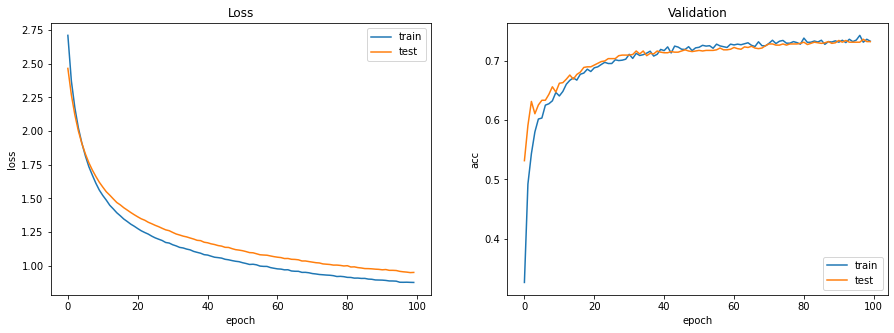

In [ ]:
plot_loss_acc(model_history1)
# Evaluamos contra test
score = modelB.evaluate(X_test, Y_test, batch_size=32)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

#### **3.1.2 EVALUACION**

In [ ]:
from sklearn.metrics import classification_report
# Calculo las clases predichas
predicted_y = modelB.predict(X_test)
predicted_y = np.argmax(np.round(predicted_y), axis=1)

# Convierto a categorico
categorical_labels = np.argmax(Y_test, axis=1)

# Mapeo con el nombre de las clases
X, Y = processed_ravdess_tess.get_categorical_classes()
mapping = dict(zip(categorical_labels, Y))

predicted_y = list(map(mapping.get, predicted_y))
categorical_labels = list(map(mapping.get, categorical_labels))

In [ ]:
# target_names = ["Emocion {}".format(i) for i in range(ravdess_tess_dataset.emotion.unique())]
print(classification_report(categorical_labels, predicted_y))

              precision    recall  f1-score   support

       angry       0.28      1.00      0.44       148
     disgust       1.00      0.52      0.68       148
        fear       0.99      0.68      0.81       148
       happy       1.00      0.51      0.67       148
     neutral       1.00      0.78      0.88       124
         sad       0.99      0.63      0.77       148
    surprise       1.00      0.28      0.44       148

    accuracy                           0.63      1012
   macro avg       0.89      0.63      0.67      1012
weighted avg       0.89      0.63      0.67      1012



#### **3.1.3 Prueba con Data Augmentation**

In [ ]:
augmented_ravdess_tess = datasetRAVDESS_augmented.append(datasetTESS_augmented, ignore_index= True)
augmented_ravdess_tess = augmented_ravdess_tess.dropna()
augmented_ravdess_tess = shuffle(augmented_ravdess_tess)
print("La version aumentada de este dataset tiene {} instancias".format(len(augmented_ravdess_tess)))
augmented_ravdess_tess.head()

La version aumentada de este dataset tiene 8096 instancias


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
3827,neutral,-266.479451,22.435677,5.050617,5.103999,-1.054804,-0.961639,-8.055769,-9.891560,-3.222189,1.931916,-4.663276,-1.599429,-1.715754,-0.141010,-1.581937,-3.634112,-1.521970,-1.596629,-6.064897,-0.883548,-2.855006,-4.023333,-0.942678,-1.974278,-2.791568,-1.049408,-1.383596,-2.504471,-4.045851,-5.495361,-5.028540,-2.055944,4.389775,11.627304,17.797038,20.082830,17.673253,9.001970,2.380878,-0.781288
7788,disgust,-436.561493,101.542511,5.839959,-8.420920,-1.688159,17.913742,-15.143816,-5.414210,-18.471807,3.202821,-12.920016,1.887601,-4.300341,5.752513,-2.542234,2.795225,-6.320455,4.214068,-1.483451,-1.191231,-1.854158,-1.318653,-4.587264,3.175848,-1.864431,3.282199,0.427020,2.996789,2.330608,2.921648,2.811657,6.685576,6.611037,7.666111,10.547272,6.450833,8.110152,6.594723,7.348959,6.583251
6761,angry,-325.512268,43.777546,-20.794352,20.259190,-35.615356,1.049899,-9.608173,-17.764067,-11.206520,3.492645,-22.966349,15.140291,-19.014004,11.085993,-5.714996,-6.086911,-3.147779,-1.567203,-9.703992,1.371684,-5.640701,-3.188108,-6.073734,-1.244804,-0.883707,5.924333,16.108850,16.595268,18.593952,9.928529,-1.070365,-1.832936,-2.071823,4.467991,5.663745,8.204926,0.928101,-0.302939,0.124041,5.685630
8297,surprise,-334.862732,53.033077,-17.412249,5.158655,-31.316618,0.114460,-19.336908,-11.721533,-16.323507,9.691947,-15.242326,10.592915,-10.742820,11.683749,-0.025824,5.278055,6.572559,8.843779,-5.110622,9.274623,-5.682571,6.171734,-3.430124,-1.587980,-1.155516,-0.174189,2.172952,5.726111,5.449984,9.500147,7.101410,8.096896,5.227662,5.219774,3.204458,2.184572,4.185641,1.759553,4.378905,0.250756
4243,disgust,-270.345450,29.474224,9.580827,4.872975,-3.296708,-8.368209,-6.887611,-7.803536,-9.554289,-5.271515,-4.843320,-0.741984,-4.215735,-2.833863,-1.012487,-2.833803,-2.562112,-0.318646,-2.803150,-1.731898,-2.231930,-2.315590,-1.760634,-1.911567,-1.977371,-1.367320,-1.781370,-0.457115,1.206836,0.785174,1.254091,1.679272,1.910056,1.772529,2.991960,2.678085,1.882810,1.414896,1.533309,1.025375


In [ ]:
print(augmented_ravdess_tess['emotion'].value_counts())

disgust     1184
happy       1184
fear        1184
surprise    1184
sad         1184
angry       1184
neutral      992
Name: emotion, dtype: int64


In [ ]:
X_train, X_test, Y_train, Y_test = processed_ravdess_tess.dataset_splitted(augmented_ravdess_tess)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_train.shape, Y_train.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test.shape, Y_test.shape))

Dimensiones del conjunto de entrenamiento. Datos: (6072, 40, 1) y clases: (6072, 7)
Dimensiones del conjunto de test. Datos: (2024, 40, 1) y clases: (2024, 7)


In [ ]:
model_aug = model_B(X_train, Y_train.shape[1])
# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

model_history1_au = model_aug.fit(X_train, Y_train,
                         batch_size=32,
                         epochs=100,
                         validation_data=(X_test, Y_test),
                         callbacks=[rlrp, es])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


190/190 [==============================] - 4s 12ms/step - loss: 2.7096 - accuracy: 0.3365 - val_loss: 2.2741 - val_accuracy: 0.5222
Epoch 2/100
190/190 [==============================] - 2s 10ms/step - loss: 2.1838 - accuracy: 0.5147 - val_loss: 2.0354 - val_accuracy: 0.6082
Epoch 3/100
190/190 [==============================] - 2s 10ms/step - loss: 1.9379 - accuracy: 0.5677 - val_loss: 1.8723 - val_accuracy: 0.6131
Epoch 4/100
190/190 [==============================] - 2s 10ms/step - loss: 1.7716 - accuracy: 0.5969 - val_loss: 1.7596 - val_accuracy: 0.6571
Epoch 5/100
190/190 [==============================] - 2s 11ms/step - loss: 1.6416 - accuracy: 0.6271 - val_loss: 1.6704 - val_accuracy: 0.6561
Epoch 6/100
190/190 [==============================] - 2s 11ms/step - loss: 1.5618 - accuracy: 0.6253 - val_loss: 1.6057 - val_accuracy: 0.6586
Epoch 7/100
190/190 [==============================] - 2s 10ms/step - loss: 1.4874 - accuracy: 0.6440 - val_loss: 1.5520 - val_accuracy: 0.6655
Epoc

64/64 [==============================] - 0s 3ms/step - loss: 0.9525 - accuracy: 0.7307
Loss: 0.9525057673454285 
Accuracy: 73.07312488555908%


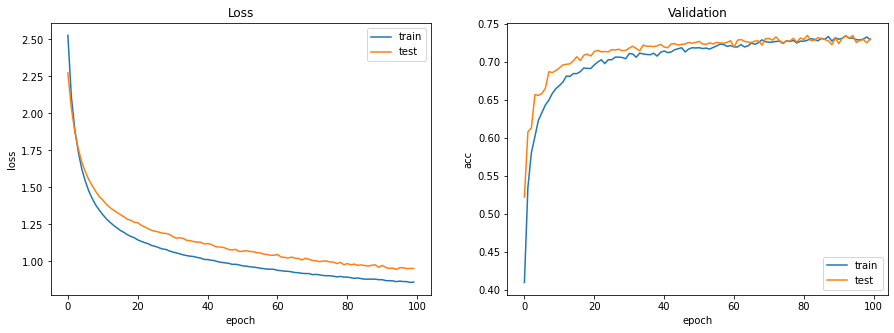

In [ ]:
plot_loss_acc(model_history1_au)
# Evaluamos contra test
score = model_aug.evaluate(X_test, Y_test, batch_size=32)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

### **3.2 PRUEBA 2: TESS + SAVEE**

In [ ]:
savee_tess_dataset = datasetSAVEE.append(datasetTESS, ignore_index=True)
savee_tess_dataset = shuffle(savee_tess_dataset)
print("El nuevo dataframe tiene {} filas".format(len(savee_tess_dataset)))
savee_tess_dataset.head()

El nuevo dataframe tiene 3280 filas


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
2358,fear,-437.968140,63.813919,7.876610,-0.246247,-8.970275,18.213743,-17.286484,-0.936487,-16.007854,5.333627,-18.847095,-7.854962,-10.595213,8.835863,-9.469554,4.103536,-2.196994,6.211494,4.226378,4.215594,-0.391661,15.637022,15.512087,22.991632,25.110155,17.406101,3.788469,6.756814,-1.372150,2.286459,4.933448,1.152041,0.464767,-3.655342,2.811790,3.366096,-1.133919,-1.027517,-3.859987,0.182710
2655,disgust,-464.932465,101.858170,20.670502,-3.757595,-6.675801,4.766084,-10.598409,5.350226,-23.908792,3.447888,-21.360456,2.127439,-8.005643,1.341408,-0.025967,5.673500,-0.977605,3.617569,-0.846898,-3.827094,-2.073822,-1.794802,-3.985968,1.146164,-4.619545,1.206068,-1.018669,0.596904,1.760861,1.639112,-0.243382,2.293111,3.705050,4.420627,12.279380,9.751394,14.928434,12.361645,8.651327,9.954115
732,fear,-337.752563,50.532494,-22.619473,21.612370,-10.799305,5.348974,-17.765219,-0.094540,-15.801779,11.060619,-22.977739,3.656958,-2.972473,-0.539205,-3.940213,-0.630606,-7.205699,10.951501,-2.234048,16.101067,16.173096,5.149178,1.598405,4.045558,-1.765051,12.676558,5.728408,4.651816,0.774341,-2.938081,-4.045528,-0.861072,-5.910703,2.306907,-2.301042,0.001777,2.227330,2.241778,4.722253,0.425466
629,sad,-527.115479,80.409698,16.980846,12.446126,11.093621,21.195267,-20.856541,-6.654828,-16.371574,10.280926,-10.490260,8.657890,-3.555453,11.668823,-2.331365,-2.790954,1.610366,1.500473,6.450917,-5.482311,2.819313,2.168891,-6.807719,-0.943865,-4.619450,-1.822157,0.213719,2.813794,2.466470,8.022853,5.003770,9.438253,9.131076,7.827302,15.682879,13.494361,13.254152,8.964339,5.769776,2.491477
2513,disgust,-435.580109,76.025284,6.073241,12.905301,5.214065,6.682615,-13.290169,4.602303,-20.702578,4.672724,-13.439818,3.254605,-5.943613,2.910067,-2.313347,0.210458,-6.358218,3.075480,0.556404,-4.743473,-1.733233,0.638096,-6.489434,-2.530132,-3.248732,0.352080,-0.554946,0.151522,-0.504773,1.099466,1.462653,2.813551,2.605080,5.627871,9.638317,10.064936,15.216961,11.609790,13.212403,8.976077


In [ ]:
savee_tess_dataset = savee_tess_dataset.dropna()
print(savee_tess_dataset['emotion'].value_counts())

neutral     520
disgust     460
happy       460
surprise    460
sad         460
fear        460
angry       460
Name: emotion, dtype: int64


In [ ]:
processed_savee_tess = ProcessData()
X_train, X_test, Y_train, Y_test = processed_savee_tess.dataset_splitted(savee_tess_dataset)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_train.shape, Y_train.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test.shape, Y_test.shape))

Dimensiones del conjunto de entrenamiento. Datos: (2460, 40, 1) y clases: (2460, 7)
Dimensiones del conjunto de test. Datos: (820, 40, 1) y clases: (820, 7)


Probamos el modelo A

In [ ]:
# model = model_A(X_train, Y_train.shape[1])
# model_history2 = model.fit(X_train, Y_train, 
#                         batch_size=32, 
#                         epochs=100, 
#                         validation_data=(X_test, Y_test))

In [ ]:
# plot_loss_acc(model_history2)
# # Evaluamos contra test
# score = model.evaluate(X_test, Y_test, batch_size=16)
# print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

#### **3.2.1 ENTRENAMIENTO**
Probamos el modelo B

In [ ]:
modelB = model_B(X_train, Y_train.shape[1])
# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

model_history2_1 = modelB.fit(X_train, Y_train,
                         batch_size=32,
                         epochs=100,
                         validation_data=(X_test, Y_test),
                         callbacks=[rlrp, es])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


77/77 [==============================] - 2s 16ms/step - loss: 2.8812 - accuracy: 0.2673 - val_loss: 2.4889 - val_accuracy: 0.6341
Epoch 2/100
77/77 [==============================] - 1s 10ms/step - loss: 2.4475 - accuracy: 0.5724 - val_loss: 2.2994 - val_accuracy: 0.6659
Epoch 3/100
77/77 [==============================] - 1s 10ms/step - loss: 2.2106 - accuracy: 0.6347 - val_loss: 2.1492 - val_accuracy: 0.7183
Epoch 4/100
77/77 [==============================] - 1s 10ms/step - loss: 2.0300 - accuracy: 0.7055 - val_loss: 2.0262 - val_accuracy: 0.7207
Epoch 5/100
77/77 [==============================] - 1s 10ms/step - loss: 1.8931 - accuracy: 0.7179 - val_loss: 1.9260 - val_accuracy: 0.7268
Epoch 6/100
77/77 [==============================] - 1s 10ms/step - loss: 1.7966 - accuracy: 0.7266 - val_loss: 1.8439 - val_accuracy: 0.7585
Epoch 7/100
77/77 [==============================] - 1s 10ms/step - loss: 1.6916 - accuracy: 0.7454 - val_loss: 1.7705 - val_accuracy: 0.7561
Epoch 8/100
77/77 

26/26 [==============================] - 0s 3ms/step - loss: 0.7493 - accuracy: 0.8439
Loss: 0.7493240237236023 
Accuracy: 84.39024686813354%


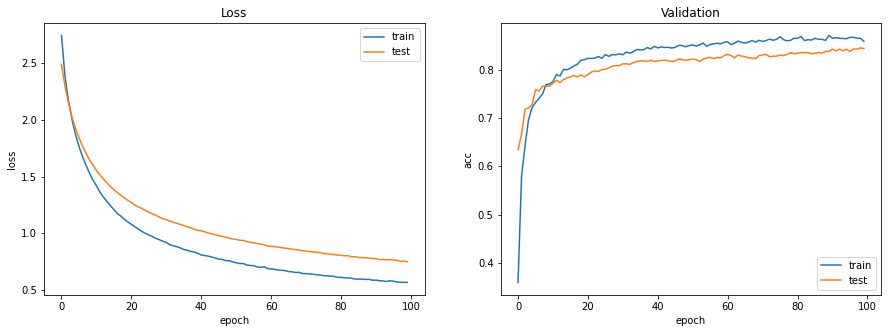

In [ ]:
plot_loss_acc(model_history2_1)
# Evaluamos contra test
score = modelB.evaluate(X_test, Y_test, batch_size=32)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

#### **3.2.2 EVALUACION**

In [ ]:
from sklearn.metrics import classification_report

predicted_y = modelB.predict(X_test)
predicted_y = np.argmax(np.round(predicted_y), axis=1)

categorical_labels = np.argmax(Y_test, axis=1)

# Mapeo con el nombre de las clases
X, Y = processed_savee_tess.get_categorical_classes()
mapping = dict(zip(categorical_labels, Y))

predicted_y = list(map(mapping.get, predicted_y))
categorical_labels = list(map(mapping.get, categorical_labels))

In [ ]:
print(classification_report(categorical_labels, predicted_y ))

              precision    recall  f1-score   support

       angry       0.38      1.00      0.55       115
     disgust       1.00      0.77      0.87       115
        fear       1.00      0.77      0.87       115
       happy       0.99      0.64      0.78       115
     neutral       1.00      0.74      0.85       130
         sad       1.00      0.82      0.90       115
    surprise       0.99      0.65      0.79       115

    accuracy                           0.77       820
   macro avg       0.91      0.77      0.80       820
weighted avg       0.91      0.77      0.80       820



#### **3.2.3 Prueba con Data Augmentation**

In [ ]:
augmented_savee_tess = datasetSAVEE_augmented.append(datasetTESS_augmented, ignore_index= True)
augmented_savee_tess = augmented_savee_tess.dropna()
augmented_savee_tess = shuffle(augmented_savee_tess)
print("La version aumentada de este dataset tiene {} instancias".format(len(augmented_savee_tess)))
augmented_savee_tess.head()

La version aumentada de este dataset tiene 6560 instancias


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
2060,angry,-230.418010,12.984202,-5.387529,8.995901,-20.135710,-7.232040,-2.770488,-12.875583,-6.307701,-2.361078,-9.551602,2.473475,-8.328517,2.934131,-0.252886,-4.623043,-0.306776,-0.953902,-2.359274,2.794546,-5.630286,-5.439030,-3.358520,-4.596453,2.290965,5.040273,7.603111,8.600715,9.008471,6.638078,4.277957,1.673902,0.560603,1.280020,3.451294,2.121242,0.631274,0.544406,-0.529517,0.051505
3347,angry,-270.694761,24.487138,-2.147072,-7.649007,-1.246460,2.405677,-5.410141,-2.457431,-6.704099,-5.241830,-2.898438,2.739406,0.627795,1.905155,1.425429,-1.614483,-2.571905,-5.067418,-5.872638,-7.705710,-2.524559,0.327814,1.201434,3.070605,7.540929,10.408899,11.452805,11.450070,7.556237,5.072956,2.839502,2.659979,1.721925,-0.756691,-0.709171,-1.666111,-0.336069,2.099312,2.482956,0.589591
3947,sad,-532.895569,69.532845,18.547831,20.456202,9.900830,15.681271,-9.940571,-6.678322,-8.889084,5.798326,-11.784546,4.719676,-3.642441,8.034163,-0.169740,0.363514,-0.109061,9.052638,-1.702492,0.123432,2.818141,-3.291779,-0.210878,-2.529390,-3.287046,2.857054,2.070113,9.556072,7.619289,11.898511,12.364193,7.687502,4.354456,8.673531,7.392745,12.337102,11.179586,6.173889,2.461725,0.466388
2079,angry,-243.894610,26.606304,0.769473,6.017351,-15.248672,-10.529895,-4.218433,-12.253661,-4.998899,-3.071887,-9.240719,1.745828,-7.767613,2.678634,0.757114,-5.746813,-1.512671,-4.286138,-8.805744,-4.839472,-6.951935,-4.404573,-0.212202,0.779812,5.486633,8.234934,9.080342,10.083780,8.846049,5.055946,1.321841,0.554984,-0.939282,-0.662450,0.217781,0.048386,-2.395408,-3.817268,-1.272364,0.304035
1664,sad,-272.770090,19.861038,14.859626,14.511757,-1.874796,-2.161136,-3.750087,-3.997783,-3.422414,-3.080721,-2.999707,-1.175208,-3.582730,1.113516,-4.221086,-3.426920,-0.807808,-3.293934,-4.728952,-2.385527,-5.189331,-4.722115,-1.914533,-0.453335,1.215056,3.528530,3.838759,0.445384,1.159615,1.187500,1.252262,4.998794,5.768125,5.896075,4.066691,1.176455,0.728556,1.256373,4.063037,3.634971


In [ ]:
print(augmented_savee_tess['emotion'].value_counts())

neutral     1040
disgust      920
happy        920
fear         920
surprise     920
sad          920
angry        920
Name: emotion, dtype: int64


In [ ]:
X_train, X_test, Y_train, Y_test = processed_savee_tess.dataset_splitted(augmented_savee_tess)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_train.shape, Y_train.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test.shape, Y_test.shape))

Dimensiones del conjunto de entrenamiento. Datos: (4920, 40, 1) y clases: (4920, 7)
Dimensiones del conjunto de test. Datos: (1640, 40, 1) y clases: (1640, 7)


In [ ]:
model_aug2 = model_B(X_train, Y_train.shape[1])
# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

model_history1_au = model_aug2.fit(X_train, Y_train,
                         batch_size=32,
                         epochs=100,
                         validation_data=(X_test, Y_test),
                         callbacks=[rlrp, es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
154/154 [==============================] - 3s 13ms/step - loss: 2.7468 - accuracy: 0.3770 - val_loss: 2.2902 - val_accuracy: 0.6506
Epoch 2/100
154/154 [==============================] - 2s 10ms/step - loss: 2.1806 - accuracy: 0.6100 - val_loss: 2.0295 - val_accuracy: 0.7159
Epoch 3/100
154/154 [==============================] - 2s 10ms/step - loss: 1.9112 - accuracy: 0.6775 - val_loss: 1.8522 - val_accuracy: 0.7311
Epoch 4/100
154/154 [==============================] - 2s 10ms/step - loss: 1.7267 - accuracy: 0.7028 - val_loss: 1.7275 - val_accuracy: 0.7579
Epoch 5/100
154/154 [==============================] - 2s 10ms/step - loss: 1.5974 - accuracy: 0.7311 - val_loss: 1.6265 - val_accuracy: 0.7683
Epoch 6/100
154/154 [==============================] - 2s 10ms/step - loss: 1.4845 - accuracy: 0.7418 - val_loss: 1.5465 - val_accuracy: 0.7713
Epoch 7/100
154/154 [==============================] - 2s 10ms/step - loss: 1.4050 - accuracy: 0.7489 - val_loss: 1.4789 - val_accuracy:

103/103 [==============================] - 0s 2ms/step - loss: 0.7145 - accuracy: 0.8433
Loss: 0.714542806148529 
Accuracy: 84.32926535606384%


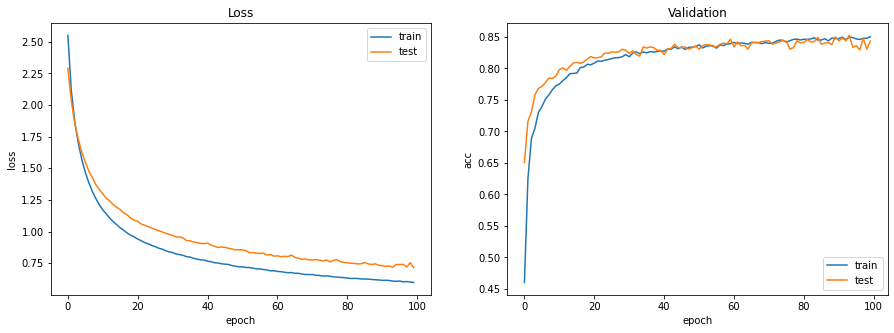

In [ ]:
plot_loss_acc(model_history1_au)
# Evaluamos contra test
score = model_aug2.evaluate(X_test, Y_test, batch_size=16)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

In [ ]:
from sklearn.metrics import classification_report

predicted_y = model_aug2.predict(X_test)
predicted_y = np.argmax(np.round(predicted_y), axis=1)

categorical_labels = np.argmax(Y_test, axis=1)

# Mapeo con el nombre de las clases
X, Y = processed_savee_tess.get_categorical_classes()
mapping = dict(zip(categorical_labels, Y))

predicted_y = list(map(mapping.get, predicted_y))
categorical_labels = list(map(mapping.get, categorical_labels))

In [ ]:
print(classification_report(categorical_labels, predicted_y))

              precision    recall  f1-score   support

       angry       0.36      0.97      0.53       230
     disgust       0.96      0.78      0.86       230
        fear       0.99      0.74      0.85       230
       happy       0.97      0.66      0.78       230
     neutral       1.00      0.74      0.85       260
         sad       1.00      0.73      0.84       230
    surprise       0.99      0.62      0.76       230

    accuracy                           0.75      1640
   macro avg       0.90      0.75      0.78      1640
weighted avg       0.90      0.75      0.78      1640



### **3.3 PRUEBA 3: RAVDESS + TESS + SAVEE**

In [ ]:
# datasetRAVDESS
ravdess_savee_tess_dataset = savee_tess_dataset.append(datasetRAVDESS, ignore_index=True)
print("El nuevo dataframe tiene {} filas".format(len(ravdess_savee_tess_dataset)))
ravdess_savee_tess_dataset = shuffle(ravdess_savee_tess_dataset)
ravdess_savee_tess_dataset.head()

El nuevo dataframe tiene 4720 filas


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
2513,sad,-414.134491,78.704971,20.114946,37.937614,-4.680203,15.948442,-7.634863,-10.195183,-5.808845,-0.526764,-12.982364,3.852681,-9.282022,9.088617,-9.760691,-0.239285,-1.076323,-4.664616,-5.046268,-3.451943,-8.343704,-5.567700,-8.745358,0.608777,-1.740235,4.443312,5.030370,1.241232,2.552199,-3.499514,-5.160975,4.535611,6.220928,10.190932,8.397882,7.072668,5.235031,5.774611,5.996107,5.253765
588,angry,-419.791595,44.769318,-8.963196,13.404624,-0.831942,11.314640,-25.340847,-7.485114,-21.854431,-4.629401,-2.599697,-0.131840,-1.578221,2.592979,1.102631,-0.647056,-4.199502,-0.564260,-3.760370,-10.085043,-4.572264,-0.838494,2.623371,14.832175,16.697306,22.817724,15.460134,14.294999,10.140079,11.123133,11.625649,7.526980,8.501954,1.980669,5.892683,4.340920,5.841063,4.271487,-2.275002,-0.729117
1747,surprise,-429.379883,96.176353,10.318429,5.404743,-2.807815,5.659296,-16.375235,7.644270,-21.741138,-3.556754,-19.573359,-3.576829,-11.469908,2.156334,-6.527137,2.565003,-5.442101,9.134283,1.332948,-1.294382,0.401997,1.900207,-5.616176,2.320229,-3.361121,1.821636,-1.998874,0.174019,-3.158694,2.517396,-0.826036,1.882857,5.402169,7.509759,12.488698,11.569602,13.612073,10.995276,10.652290,7.825648
3407,NaN,-639.153320,78.333405,-7.773652,16.255728,5.534957,4.175819,-26.209743,7.147804,-8.506223,-3.833080,1.850278,-3.713302,-6.247783,0.718132,-7.237792,2.086442,-4.995892,0.416770,-4.565614,-1.675265,-5.042173,-2.740127,-2.668342,-3.830658,-5.012235,-1.136800,-2.394998,-1.877705,-1.909954,-2.600168,-4.733542,-0.654522,-3.242612,-1.634608,-2.411409,-0.763663,-4.320214,-4.467992,-3.959566,-1.513513
1226,sad,-375.476593,70.025620,24.258970,44.624725,-11.014941,10.175508,-6.005273,-3.178115,-4.315784,2.181001,-13.236867,7.718135,-10.272397,9.355149,-6.931213,-1.267055,2.265157,-2.264965,-10.014305,-2.380092,-5.846509,-4.382808,-4.821205,4.740850,2.127910,6.084557,4.034672,0.869576,1.184665,3.556196,4.836654,12.246416,7.220956,2.018448,0.730681,1.965207,6.073575,3.547941,1.534791,-1.785436


In [ ]:
ravdess_savee_tess_dataset = ravdess_savee_tess_dataset.dropna()
print(ravdess_savee_tess_dataset['emotion'].value_counts())

disgust     652
happy       652
surprise    652
sad         652
fear        652
angry       652
neutral     616
Name: emotion, dtype: int64


In [ ]:
processed_savee_tess_ravdess = ProcessData()
X_train, X_test, Y_train, Y_test = processed_savee_tess_ravdess.dataset_splitted(ravdess_savee_tess_dataset)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_train.shape, Y_train.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test.shape, Y_test.shape))

Dimensiones del conjunto de entrenamiento. Datos: (3396, 40, 1) y clases: (3396, 7)
Dimensiones del conjunto de test. Datos: (1132, 40, 1) y clases: (1132, 7)


Probamos con el modelo A

In [ ]:
# modelA = model_A(X_train, Y_train.shape[1])
# model_history3 = modelA.fit(X_train, Y_train, 
#                         batch_size=32, 
#                         epochs=100, 
#                         validation_data=(X_test, Y_test))

In [ ]:
# plot_loss_acc(model_history3)
# # Evaluamos contra test
# score = modelA.evaluate(X_test, Y_test, batch_size=16)
# print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

#### **3.3.1 ENTRENAMIENTO**
Probamos el modelo B

In [ ]:
modelB = model_B(X_train, Y_train.shape[1])
# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

model_history3_1 = modelB.fit(X_train, Y_train,
                         batch_size=32,
                         epochs=100,
                         validation_data=(X_test, Y_test),
                         callbacks=[rlrp, es])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


107/107 [==============================] - 3s 14ms/step - loss: 2.8840 - accuracy: 0.2321 - val_loss: 2.4817 - val_accuracy: 0.3896
Epoch 2/100
107/107 [==============================] - 1s 10ms/step - loss: 2.4794 - accuracy: 0.3973 - val_loss: 2.3002 - val_accuracy: 0.4929
Epoch 3/100
107/107 [==============================] - 1s 11ms/step - loss: 2.2686 - accuracy: 0.4800 - val_loss: 2.1615 - val_accuracy: 0.5389
Epoch 4/100
107/107 [==============================] - 1s 10ms/step - loss: 2.1092 - accuracy: 0.4905 - val_loss: 2.0496 - val_accuracy: 0.5442
Epoch 5/100
107/107 [==============================] - 1s 10ms/step - loss: 2.0059 - accuracy: 0.5116 - val_loss: 1.9620 - val_accuracy: 0.5610
Epoch 6/100
107/107 [==============================] - 1s 11ms/step - loss: 1.9117 - accuracy: 0.5187 - val_loss: 1.8917 - val_accuracy: 0.5919
Epoch 7/100
107/107 [==============================] - 1s 10ms/step - loss: 1.8226 - accuracy: 0.5406 - val_loss: 1.8325 - val_accuracy: 0.5928
Epoc

36/36 [==============================] - 0s 3ms/step - loss: 1.1191 - accuracy: 0.6696
Loss: 1.1190812587738037 
Accuracy: 66.96113348007202%


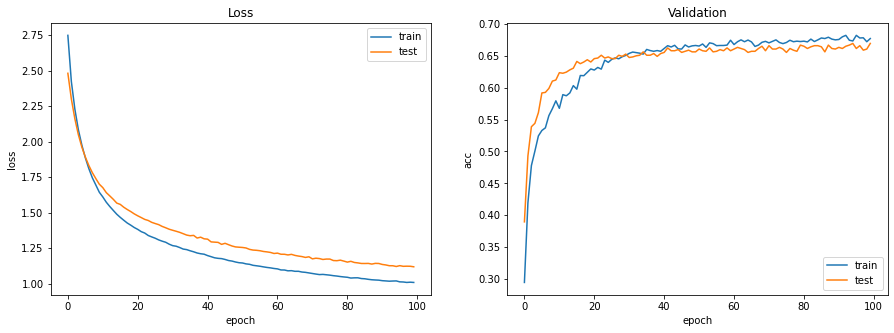

In [ ]:
plot_loss_acc(model_history3_1)
# Evaluamos contra test
score = modelB.evaluate(X_test, Y_test, batch_size=32)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

#### **3.3.2 EVALUACION**

In [ ]:
from sklearn.metrics import classification_report

predicted_y = modelB.predict(X_test)
predicted_y = np.argmax(np.round(predicted_y),axis=1)

categorical_labels = np.argmax(Y_test, axis=1)

# Mapeo con el nombre de las clases
X, Y = processed_savee_tess_ravdess.get_categorical_classes()
mapping = dict(zip(categorical_labels, Y))

# Mapeo el nombre de las clases
predicted_y = list(map(mapping.get, predicted_y))
categorical_labels = list(map(mapping.get, categorical_labels))

In [ ]:
print(classification_report(categorical_labels, predicted_y))

              precision    recall  f1-score   support

       angry       0.25      1.00      0.40       163
     disgust       1.00      0.42      0.59       163
        fear       0.98      0.54      0.70       163
       happy       1.00      0.45      0.62       163
     neutral       1.00      0.62      0.76       154
         sad       1.00      0.61      0.76       163
    surprise       1.00      0.31      0.47       163

    accuracy                           0.56      1132
   macro avg       0.89      0.56      0.61      1132
weighted avg       0.89      0.56      0.61      1132



#### **3.3.3 Prueba con Data Augmentation**

In [ ]:
augmented_savee_tess_ravdess = augmented_ravdess_tess.append(datasetTESS_augmented, ignore_index= True)
augmented_savee_tess_ravdess = augmented_savee_tess_ravdess.dropna()
augmented_savee_tess_ravdess = shuffle(augmented_savee_tess_ravdess)
print("La version aumentada de este dataset tiene {} instancias".format(len(augmented_savee_tess)))

augmented_savee_tess_ravdess.head()

In [ ]:
print(augmented_savee_tess_ravdess['emotion'].value_counts())

In [ ]:
X_train, X_test, Y_train, Y_test = processed_savee_tess_ravdess.dataset_splitted(augmented_savee_tess_ravdess)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_train.shape, Y_train.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test.shape, Y_test.shape))

In [ ]:
model_aug3 = model_B(X_train, Y_train.shape[1])
# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

model_history1_au = model_aug3.fit(X_train, Y_train,
                         batch_size=32,
                         epochs=100,
                         validation_data=(X_test, Y_test),
                         callbacks=[rlrp, es])

In [ ]:
plot_loss_acc(model_history1_au)
# Evaluamos contra test
score = model_aug3.evaluate(X_test, Y_test, batch_size=32)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))